In [7]:
import os

folder_path = r"C:\Users\ASUS\OneDrive\Desktop\SDA\week 3\srcmod2024-12-02FSP"

def count_segments(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
    return content.count("SEGMENT")  # Adjust if the segment identifier differs

for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    if count_segments(file_path) > 1:
        os.remove(file_path)

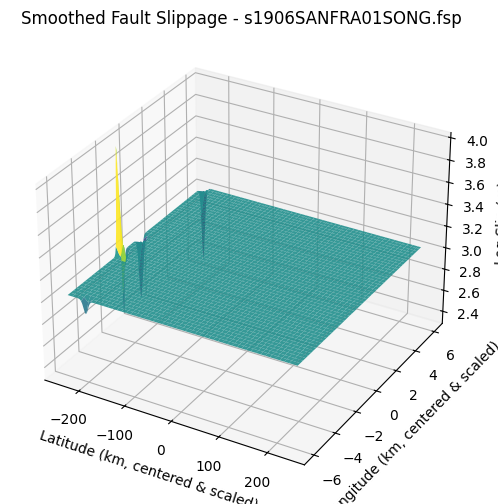

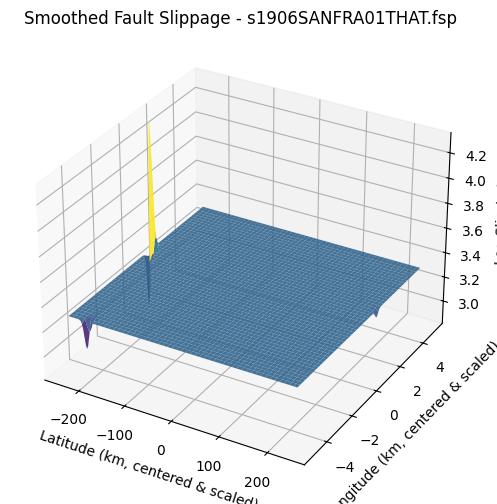

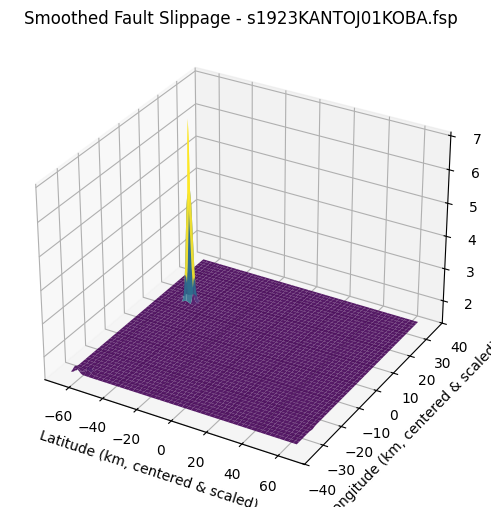

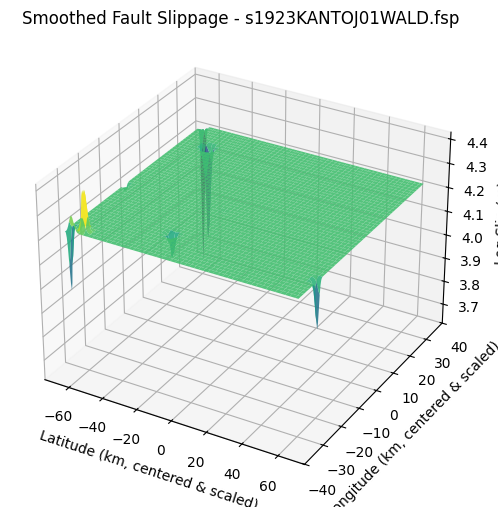

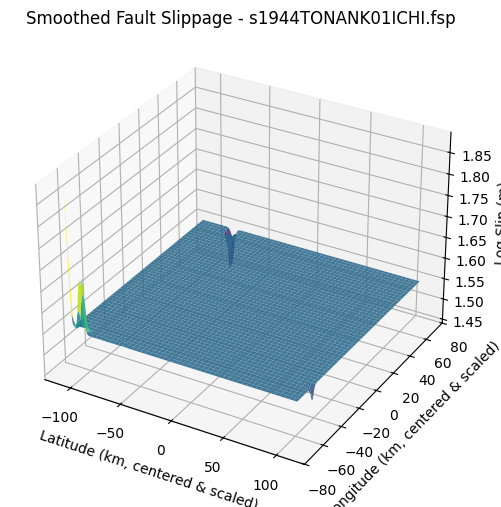

In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.ndimage import gaussian_filter

# Define paths
folder_path = r"C:\Users\ASUS\OneDrive\Desktop\SDA\week 3\srcmod2024-12-02FSP"

# Function to extract LEN and WID from a file
def extract_size(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()
    
    match = re.search(r"Size\s*:\s*LEN\s*=\s*([\d.]+)\s*km\s*WID\s*=\s*([\d.]+)\s*km", content)
    if match:
        length = float(match.group(1))
        width = float(match.group(2))
        return length, width
    return None, None

# Read first 5 files
fsp_files = [f for f in os.listdir(folder_path) if f.endswith(".fsp")][:5]

if not fsp_files:
    raise FileNotFoundError("No .fsp files found in the folder!")

for fsp_file in fsp_files:
    file_path = os.path.join(folder_path, fsp_file)

    # Get the LEN and WID of the current file
    file_len, file_wid = extract_size(file_path)
    if not file_len or not file_wid:
        print(f"Skipping {fsp_file}: LEN and WID not found!")
        continue

    # Read fault data (LAT, LON, SLIP)
    fault_data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = re.findall(r"[-+]?\d*\.\d+|\d+", line)  # Extract numbers
            if len(values) >= 3:  # Ensure at least lat, lon, and slip are present
                lat, lon, slip = float(values[0]), float(values[1]), abs(float(values[-1]))
                fault_data.append([lat, lon, slip])

    if not fault_data:
        print(f"Skipping {fsp_file}: No valid fault data found!")
        continue

    fault_data = np.array(fault_data, dtype=float)

    # Ensure the array is 2D
    if fault_data.ndim == 1:
        print(f"Skipping {fsp_file}: Fault data is not properly structured!")
        continue

    Lat, Lon, Slip = fault_data[:, 0], fault_data[:, 1], fault_data[:, 2]

    # **1. Centering the Fault Coordinates**  
    lat_center = (np.max(Lat) + np.min(Lat)) / 2
    lon_center = (np.max(Lon) + np.min(Lon)) / 2

    Lat_centered = Lat - lat_center
    Lon_centered = Lon - lon_center

    # **2. Scaling based on actual distances**  
    lat_scale_factor = file_len / (np.max(Lat) - np.min(Lat))
    lon_scale_factor = file_wid / (np.max(Lon) - np.min(Lon))

    Lat_scaled = Lat_centered * lat_scale_factor
    Lon_scaled = Lon_centered * lon_scale_factor

    # **Fix 1: Remove duplicate Lat/Lon points**
    unique_points, unique_indices = np.unique(np.column_stack((Lat_scaled, Lon_scaled)), axis=0, return_index=True)
    Lat_scaled, Lon_scaled, Slip = unique_points[:, 0], unique_points[:, 1], Slip[unique_indices]

    # **Fix 2: Add small noise to avoid singular matrix error**
    Lat_scaled += np.random.normal(0, 1e-5, size=Lat_scaled.shape)
    Lon_scaled += np.random.normal(0, 1e-5, size=Lon_scaled.shape)

    # Convert Slip to log scale to handle large variations
    Slip = np.log1p(Slip)

    # **3. Interpolation Grid (keeping centered coordinates)**
    grid_x, grid_y = np.mgrid[
        np.min(Lat_scaled):np.max(Lat_scaled):200j, 
        np.min(Lon_scaled):np.max(Lon_scaled):200j
    ]

    # **4. Apply Gaussian RBF for smooth interpolation**
    rbf = RBFInterpolator(np.column_stack((Lat_scaled, Lon_scaled)), Slip, kernel='gaussian', epsilon=10)
    grid_slip = rbf(np.column_stack((grid_x.ravel(), grid_y.ravel()))).reshape(grid_x.shape)

    # Apply Gaussian filter for extra smoothness
    grid_slip = gaussian_filter(grid_slip, sigma=2)  

    # **5. 3D Plot**
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(grid_x, grid_y, grid_slip, cmap="viridis", edgecolor='none', alpha=0.9)

    ax.set_xlabel("Latitude (km, centered & scaled)")
    ax.set_ylabel("Longitude (km, centered & scaled)")
    ax.set_zlabel("Log Slip (m)")
    plt.title(f"Smoothed Fault Slippage - {fsp_file}")

    plt.show()
